In [1]:
import os, sys
os.chdir(os.path.abspath('..'))

In [2]:
import json, pickle
import argparse

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from torch.utils.tensorboard import SummaryWriter

In [3]:
%load_ext autoreload
%autoreload 2

import src.utils as utils
import src.preprocess_lib as preprocess_lib

In [4]:
config_dir = 'config_files/'
config_file = 'config0.json'
with open(config_dir + config_file, 'r') as f: config = json.load(f)

In [69]:
config["data"]["subsample_rate"]["user"] = 100
config["data"]["condition_tag_list"] = ["months", "weekdays", "day_befores"]
config["data"]["ampute_params"]["b"] = 5

In [70]:
trainset, valset, conditioner, user_ids, months, condition_set, X_test, X_missing, num_missing_days, nonzero_mean, nonzero_std = preprocess_lib.prepare_data(config["data"])

Dataset: goi4_dp_full_Gipuzkoa
Loaded 2522880 consumption profiles from 365 dates and 6912 users.
Removing 15 users with all-zero consumption profiles
Removing 67 users with any-negative consumption profiles
Amputation Parameters...................a=0.85, b=5
Mean of enrolments: 53.03
Number of Training Points...............12414
Number of Testing Points.................5037
Number of Validation Points..............4063
Number of Missing Points.................3671


In [71]:
targets_train = trainset.inputs
inputs_train = condition_set["train"]["day_befores"]
context_train = conditioner.transform(condition_set["train"])[:,:-24]

targets_val = valset.inputs
inputs_val = condition_set["val"]["day_befores"]
context_val = conditioner.transform(condition_set["val"])[:,:-24]

targets_test = X_test
inputs_test = condition_set["test"]["day_befores"]
context_test = conditioner.transform(condition_set["test"])[:,:-24]

In [72]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, targets, inputs, context):
        self.targets = torch.tensor(targets).float()
        self.inputs = torch.tensor(inputs).float()
        self.context = torch.tensor(context).float()

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return  self.inputs[idx], self.context[idx], self.targets[idx]

In [73]:
trainset_custom = CustomDataset(targets_train, inputs_train, context_train)
valset_custom = CustomDataset(targets_val, inputs_val, context_val)
testset_custom = CustomDataset(targets_test, inputs_test, context_test)

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class QuantileRegressionNetwork(nn.Module):
    def __init__(self, input_size, context_size, hidden_sizes, output_size, quantiles=[0.1, 0.5, 0.9], device=None):
        """
        Initialize the Quantile Regression Network.

        Parameters:
            input_size (int): Size of the input time series.
            context_size (int): Size of the contextual information.
            hidden_sizes (list of int): List of sizes for each hidden layer.
            output_size (int): Size of the output (forecast horizon).
            quantiles (list of float): List of quantiles to predict.
            device (torch.device): The device to run the model on (CPU or GPU). Defaults to CPU if None.
        """
        super(QuantileRegressionNetwork, self).__init__()
        
        # Define the quantiles
        self.quantiles = quantiles

        # Set the device (defaults to CPU if not provided)
        self.device = device if device else torch.device('cpu')
        
        # Build the fully connected layers dynamically
        layers = []
        prev_size = input_size + context_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        
        # Final output layer
        layers.append(nn.Linear(prev_size, output_size * len(quantiles)))
        
        # Create a sequential container with all layers
        self.network = nn.Sequential(*layers)

        # Move the model to the specified device
        self.to(self.device)

    def forward(self, input_series, context_info):
        # Concatenate input series and context information along the feature dimension
        x = torch.cat((input_series, context_info), dim=-1)
        
        # Move inputs to the correct device
        x = x.to(self.device)
        
        # Pass through the network
        x = self.network(x)
        
        # Reshape the output to (batch_size, output_size, num_quantiles)
        batch_size = x.size(0)
        x = x.view(batch_size, -1, len(self.quantiles))
        
        return x

    def quantile_loss(self, predictions, targets):
        """
        Compute the quantile loss for multiple quantiles.
        
        Parameters:
            predictions (torch.Tensor): Predicted quantiles with shape (batch_size, output_size, num_quantiles)
            targets (torch.Tensor): Actual target values with shape (batch_size, output_size)

        Returns:
            torch.Tensor: The computed quantile loss
        """
        loss = 0.0
        targets = targets.to(self.device)  # Move targets to the correct device
        for i, q in enumerate(self.quantiles):
            errors = targets - predictions[:, :, i]
            loss += torch.mean(torch.max((q - 1) * errors, q * errors))
        return loss

    def validate(self, val_loader):
        """
        Validate the model using a validation DataLoader.

        Parameters:
            val_loader (DataLoader): DataLoader containing validation data

        Returns:
            float: The average loss over the validation set
        """
        self.eval()  # Set the model to evaluation mode
        val_loss = 0.0

        with torch.no_grad():  # Disable gradient computation
            for input_series, context_info, targets in val_loader:
                # Move input tensors to the appropriate device
                input_series, context_info, targets = input_series.to(self.device), context_info.to(self.device), targets.to(self.device)

                # Forward pass
                quantile_predictions = self(input_series, context_info)
                
                # Calculate the loss
                loss = self.quantile_loss(quantile_predictions, targets)
                val_loss += loss.item()

        return val_loss / len(val_loader)

    def train_model(self, train_loader, val_loader, num_epochs, learning_rate, patience=5):
        """
        Train the model using a specified DataLoader and perform early stopping based on validation loss.

        Parameters:
            train_loader (DataLoader): DataLoader containing training data
            val_loader (DataLoader): DataLoader containing validation data
            num_epochs (int): Number of epochs to train the model
            learning_rate (float): Learning rate for the optimizer
            patience (int): Number of epochs with no improvement to stop training early
        """
        # Optimizer
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
        best_val_loss = np.inf
        epochs_without_improvement = 0

        for epoch in range(num_epochs):
            # Training loop
            self.train()  # Set the model to training mode
            epoch_loss = 0.0
            for input_series, context_info, targets in train_loader:
                # Move input tensors to the correct device
                input_series, context_info, targets = input_series.to(self.device), context_info.to(self.device), targets.to(self.device)

                # Forward pass
                quantile_predictions = self(input_series, context_info)
                
                # Calculate the loss
                loss = self.quantile_loss(quantile_predictions, targets)
                
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            average_epoch_loss = epoch_loss / len(train_loader)
            print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_epoch_loss:.4f}")

            # Validate the model
            val_loss = self.validate(val_loader)
            print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}")

            # Check for early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break


In [75]:
train_loader = torch.utils.data.DataLoader(trainset_custom, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset_custom, batch_size=1024, shuffle=False)

# Hyperparameters for model
hidden_sizes = [250]*3 
quantiles = [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9]  # List of quantiles to predict

In [76]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

model = QuantileRegressionNetwork(input_size=trainset_custom[0][0].shape[0], 
                                  context_size=trainset_custom[0][1].shape[0], 
                                  output_size=trainset_custom[0][2].shape[0], 
                                  hidden_sizes=hidden_sizes, 
                                  quantiles=quantiles,
                                  device=device)

In [77]:
num_epochs = 100
lr = 1e-3

In [78]:
model.train_model(train_loader, val_loader, num_epochs, lr, patience=5)

Epoch 1/100, Training Loss: 1.3801
Epoch 1/100, Validation Loss: 1.1948
Epoch 2/100, Training Loss: 1.1923
Epoch 2/100, Validation Loss: 1.1736
Epoch 3/100, Training Loss: 1.1604
Epoch 3/100, Validation Loss: 1.1394
Epoch 4/100, Training Loss: 1.1380
Epoch 4/100, Validation Loss: 1.1343
Epoch 5/100, Training Loss: 1.1203
Epoch 5/100, Validation Loss: 1.1013
Epoch 6/100, Training Loss: 1.1059
Epoch 6/100, Validation Loss: 1.1035
Epoch 7/100, Training Loss: 1.1017
Epoch 7/100, Validation Loss: 1.1079
Epoch 8/100, Training Loss: 1.0838
Epoch 8/100, Validation Loss: 1.0986
Epoch 9/100, Training Loss: 1.0729
Epoch 9/100, Validation Loss: 1.0877
Epoch 10/100, Training Loss: 1.0651
Epoch 10/100, Validation Loss: 1.0943
Epoch 11/100, Training Loss: 1.0584
Epoch 11/100, Validation Loss: 1.0877
Epoch 12/100, Training Loss: 1.0483
Epoch 12/100, Validation Loss: 1.0776
Epoch 13/100, Training Loss: 1.0376
Epoch 13/100, Validation Loss: 1.0841
Epoch 14/100, Training Loss: 1.0291
Epoch 14/100, Valida

In [82]:
estimations_test = model(torch.tensor(inputs_test).float().to(device), torch.tensor(context_test).float().to(device)).detach().cpu().numpy().transpose(2, 0, 1)
estimations_test_denorm = utils.zero_preserved_log_denormalize(estimations_test, nonzero_mean, nonzero_std, log_input=True).reshape(quantiles.__len__(),user_ids["train"][-1]+1,-1)
X_test_denorm = utils.zero_preserved_log_denormalize(X_test, nonzero_mean, nonzero_std, log_input=True).reshape(user_ids["train"][-1]+1,-1)

In [83]:
user_idx = 42

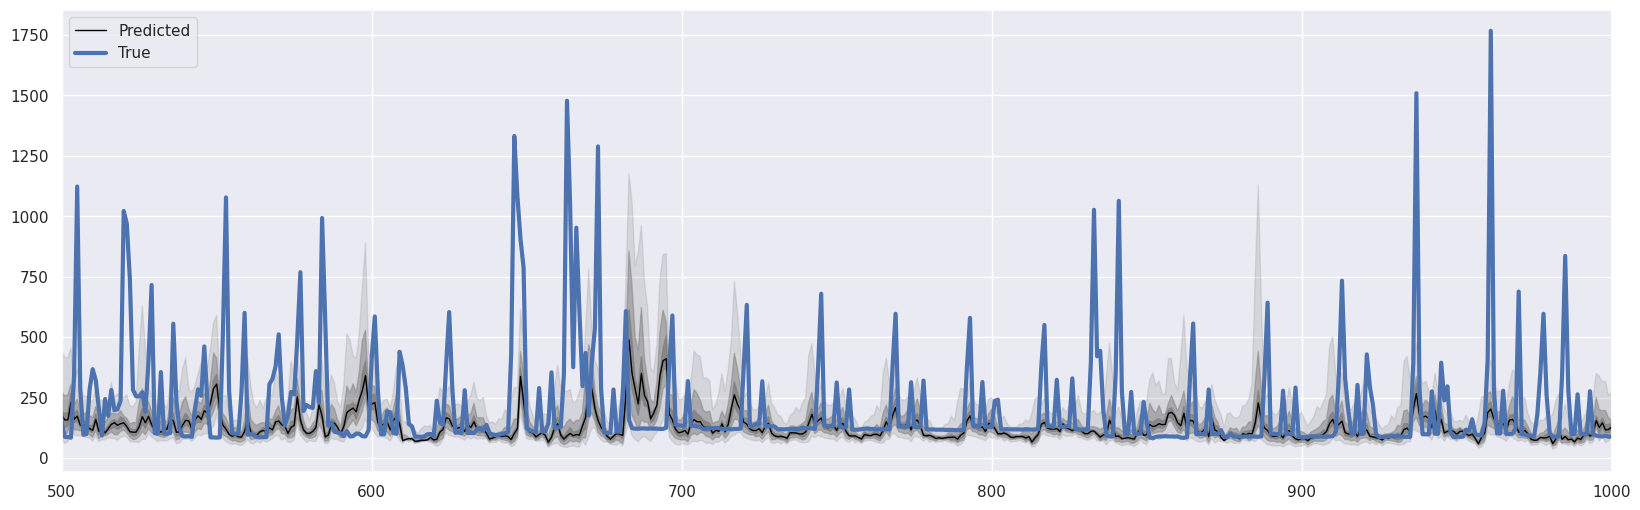

In [84]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(estimations_test_denorm[quantiles.__len__()//2,user_idx,:], label="Predicted", color="black", lw=1)
for i in range(quantiles.__len__()//2):
    ax.fill_between(np.arange(estimations_test_denorm.shape[2]), estimations_test_denorm[i,user_idx,:], estimations_test_denorm[-(i+1),user_idx,:], alpha=2*quantiles[i], color="gray")

ax.plot(X_test_denorm[user_idx], label="True", lw=3)
ax.legend()

plt.xlim(500, 1000)
plt.show()


In [85]:
def calculate_quantile_loss(predictions, targets, quantiles):
    """
    Calculate the average quantile loss for multiple quantiles.
    
    Parameters:
        predictions (torch.Tensor): Predicted quantiles with shape (batch_size, output_size, num_quantiles)
        targets (torch.Tensor): Actual target values with shape (batch_size, output_size)
        quantiles (list of float): List of quantiles

    Returns:
        float: The average quantile loss over the predictions
    """
    total_loss = 0.0
    batch_size = targets.size(0)
    
    for i, q in enumerate(quantiles):
        errors = targets - predictions[i, :, :]
        loss = torch.max((q - 1) * errors, q * errors).mean()
        total_loss += loss.item()
    
    return total_loss / len(quantiles)

In [86]:
user_losses = np.zeros((user_ids["train"][-1]+1))
for i in range(user_ids["train"][-1]+1):
    user_losses[i] = calculate_quantile_loss(torch.tensor(estimations_test_denorm).float()[:,[i],:], torch.tensor(X_test_denorm)[[i],:], quantiles)


In [87]:
user_losses.mean()

52.44804832170954

In [81]:
user_losses.mean()

48.17342840958686

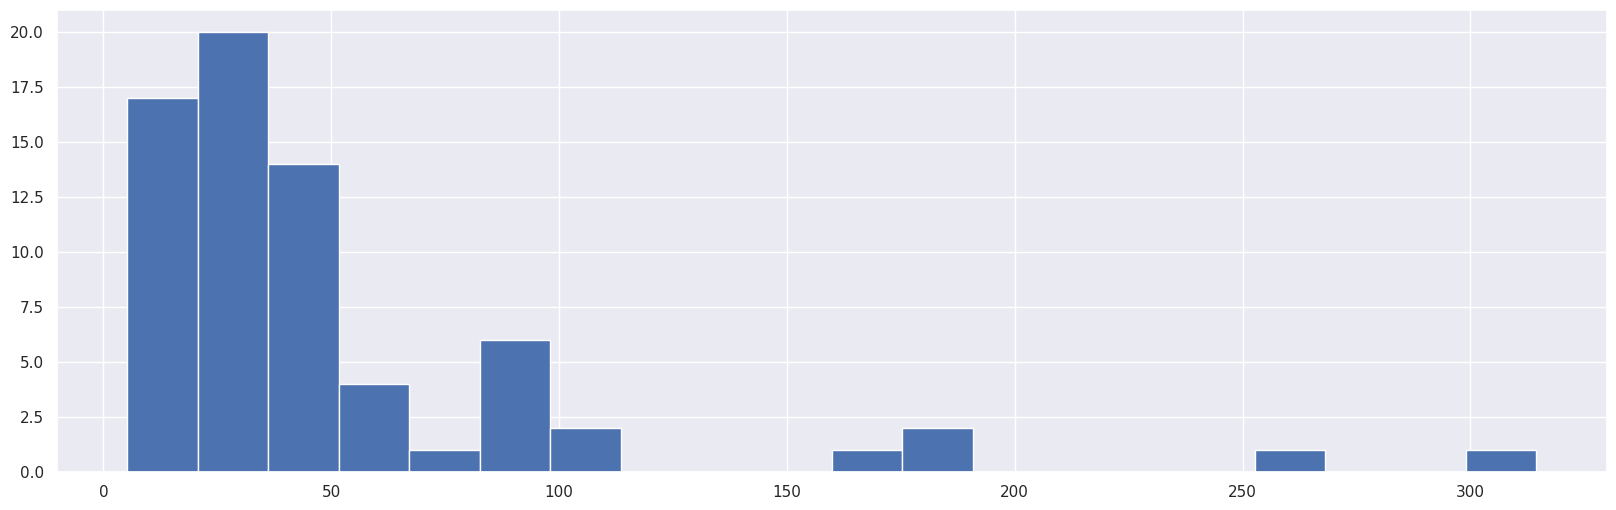

In [88]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.hist(user_losses, bins=20)
plt.show()

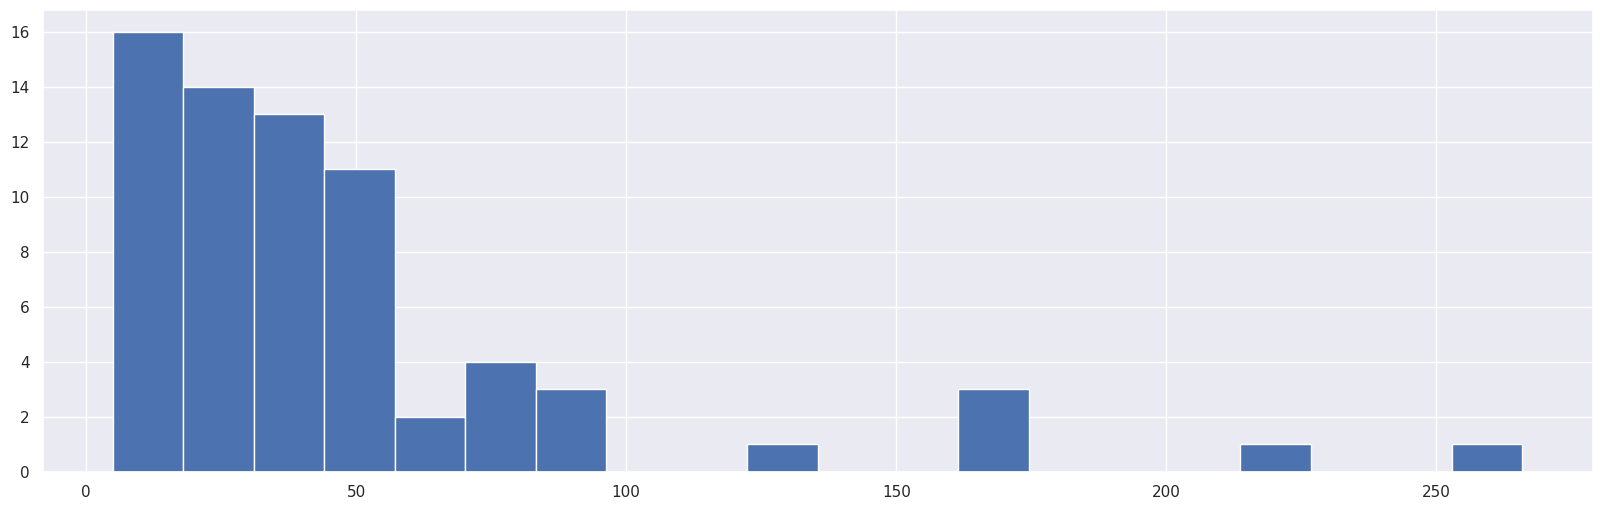

In [68]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.hist(user_losses, bins=20)
plt.show()


In [51]:
torch.tensor(X_test_denorm).shape

torch.Size([69, 1752])

In [ ]:
calculate_quantile_loss(torch.tensor(estimations_test_denorm).float(), torch.tensor(X_test_denorm), quantiles)

In [46]:
## calculate rmse
def calculate_rmse(predictions, targets):
    """
    Calculate the root mean squared error between predictions and targets.
    
    Parameters:
        predictions (torch.Tensor): Predicted values
        targets (torch.Tensor): Actual target values

    Returns:
        float: The root mean squared error between predictions and targets
    """
    return torch.mean(torch.sqrt(torch.mean((predictions - targets) ** 2, dim=-1)), dim=-1)

In [47]:
calculate_rmse(torch.tensor(estimations_test_denorm).float(), torch.tensor(X_test_denorm))

tensor([280.6606, 253.6417, 237.7881, 231.4103, 229.4737, 244.6258, 349.3375],
       dtype=torch.float64)